# Observational study and Propensity score matching 

- Causal Inference
-- The Definition of Causal Effect
1.2  Assumptions of Estimating Causal Effect
1.3  Confounders
1.4  Randomized Trials v.s. Observational Studies
1.5  Matching
1.5.1  Propensity Scores
1.6  Implementation
- Reference

In [12]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
# os.chdir(os.path.join('..', '..', 'notebook_format'))
# from formats import load_style
# load_style(plot_style=False)

In [13]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
# %load_ext autoreload
# %autoreload 2
# %config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

%watermark -a 'Vince' -d -t -v -p numpy,scipy,pandas,sklearn,matplotlib,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Vince 2020-09-30 11:24:57 

CPython 3.7.4
IPython 7.13.0

numpy 1.18.1
scipy 1.4.1
pandas 1.0.3
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.1



#### Implementation
I'll be using the [Right Heart Catheterization dataset](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/rhc.html).    
The csv file can be downloaded from the following [link](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/rhc.csv).

In [19]:
# we'll only be working with a subset of the variables in the raw dataset,
# feel free to experiment with more
AGE = 'age'
MEANBP1 = 'meanbp1'
CAT1 = 'cat1'
SEX = 'sex'
DEATH = 'death' # outcome variable in the our raw data
SWANG1 = 'swang1' # treatment variable in our raw data
TREATMENT = 'treatment'

num_cols = [AGE, MEANBP1]
cat_cols = [CAT1, SEX, DEATH, SWANG1]

input_path = 'rhc.csv'
dtype = {col: 'category' for col in cat_cols}
df = pd.read_csv(input_path, usecols=num_cols + cat_cols, dtype=dtype)
print(df.shape)
df.head()

(5735, 6)


,cat1,death,age,sex,meanbp1,swang1
0,COPD,No,70.25098,Male,41.0,No RHC
1,MOSF w/Sepsis,Yes,78.17896,Female,63.0,RHC
2,MOSF w/Malignancy,No,46.09198,Female,57.0,RHC
3,ARF,Yes,75.33197,Female,55.0,No RHC
4,MOSF w/Sepsis,Yes,67.90997,Male,65.0,RHC


In [20]:
# Usually, our treatment group will be smaller than the control group.
# replace this column with treatment yes or no
df[SWANG1].value_counts()

No RHC    3551
RHC       2184
Name: swang1, dtype: int64

In [21]:
# replace these values with shorter names
df[CAT1].value_counts()

ARF                  2490
MOSF w/Sepsis        1227
COPD                  457
CHF                   456
Coma                  436
MOSF w/Malignancy     399
Cirrhosis             224
Lung Cancer            39
Colon Cancer            7
Name: cat1, dtype: int64

In [22]:
cat1_col_mapping = {
    'ARF': 'arf',
    'MOSF w/Sepsis': 'mosf_sepsis',
    'COPD': 'copd',
    'CHF': 'chf',
    'Coma': 'coma',
    'MOSF w/Malignancy': 'mosf',
    'Cirrhosis': 'cirrhosis',
    'Lung Cancer': 'lung_cancer',
    'Colon Cancer': 'colon_cancer'
}
df[CAT1] = df[CAT1].replace(cat1_col_mapping)

# convert features' value to numerical value, and store the
# numerical value to the original value mapping
col_mappings = {}
for col in (DEATH, SWANG1, SEX):
    col_mapping = dict(enumerate(df[col].cat.categories))
    col_mappings[col] = col_mapping
print(col_mappings)

for col in (DEATH, SWANG1, SEX):
    df[col] = df[col].cat.codes

df = df.rename({SWANG1: TREATMENT}, axis=1)
df.head()

{'death': {0: 'No', 1: 'Yes'}, 'swang1': {0: 'No RHC', 1: 'RHC'}, 'sex': {0: 'Female', 1: 'Male'}}


,cat1,death,age,sex,meanbp1,treatment
0,copd,0,70.25098,1,41.0,0
1,mosf_sepsis,1,78.17896,0,63.0,1
2,mosf,0,46.09198,0,57.0,1
3,arf,1,75.33197,0,55.0,0
4,mosf_sepsis,1,67.90997,1,65.0,1


In [23]:
cat_cols = [CAT1]
df_one_hot = pd.get_dummies(df[cat_cols], drop_first=True)
df_cleaned = pd.concat([df[num_cols], df_one_hot, df[[SEX, TREATMENT, DEATH]]], axis=1)
df_cleaned.head()

,age,meanbp1,cat1_chf,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_copd,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex,treatment,death
0,70.25098,41.0,0,0,0,0,1,0,0,0,1,0,0
1,78.17896,63.0,0,0,0,0,0,0,0,1,0,1,1
2,46.09198,57.0,0,0,0,0,0,0,1,0,0,1,0
3,75.33197,55.0,0,0,0,0,0,0,0,0,0,0,1
4,67.90997,65.0,0,0,0,0,0,0,0,1,1,1,1


Given all of these covariates and our column **treatment** that indicates whether the subject received the treatment or control, we wish to have a quantitative way of measuring whether our covariates are balanced between the two groups.

To assess whether balance has been achieved, we can look at standardized mean differences (smd), which is calculated by the difference in the means between the two groups divided by the pooled standard deviation.

In [24]:
features = df_cleaned.columns.tolist()
features.remove(TREATMENT)
features.remove(DEATH)
agg_operations = {TREATMENT: 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features
})

table_one = df_cleaned.groupby(TREATMENT).agg(agg_operations)
# merge MultiIndex columns together into 1 level
# table_one.columns = ['_'.join(col) for col in table_one.columns.values]
table_one.head()

treatment        age               meanbp1             cat1_chf  \
              count       mean        std       mean        std      mean   
treatment                                                                   
0              3551  61.760926  17.287674  84.868629  38.874134  0.069558   
1              2184  60.749836  15.630698  68.197802  34.242209  0.095696   

                    cat1_cirrhosis           cat1_colon_cancer  ... cat1_copd  \
                std           mean       std              mean  ...      mean   
treatment                                                       ...             
0          0.254436       0.049282  0.216486          0.001690  ...  0.112363   
1          0.294241       0.022436  0.148130          0.000458  ...  0.026557   

                    cat1_lung_cancer           cat1_mosf            \
                std             mean       std      mean       std   
treatment                                                            
0          0.315857         0.009575  0.097395  0.067868  0.251555   
1          0.160821         0.002289  0.047804  0.072344  0.259117   

          cat1_mosf_sepsis                 sex            
                      mean       std      mean       std  
treatment                                                 
0                 0.148409  0.355555  0.539003  0.498547  
1                 0.320513  0.466781  0.585165  0.492806  

[2 rows x 23 columns]

In [25]:
def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    feature_smds = []
    for feature in features:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features, 'smd': feature_smds})


table_one_smd = compute_table_one_smd(table_one)
table_one_smd

,features,smd
0,age,0.0614
1,meanbp1,0.4551
2,cat1_chf,0.0950
3,cat1_cirrhosis,0.1447
4,cat1_colon_cancer,0.0376
5,cat1_coma,0.2073
6,cat1_copd,0.3424
7,cat1_lung_cancer,0.0950
8,cat1_mosf,0.0175
9,cat1_mosf_sepsis,0.4148


In [26]:
# The next few code chunk will actually fit the propensity score.
# treatment will be our label for estimating the propensity score,
# and death is the outcome that we care about, thus is also removed
# from the step that is estimating the propensity score
death = df_cleaned[DEATH]
treatment = df_cleaned[TREATMENT]
df_cleaned = df_cleaned.drop([DEATH, TREATMENT], axis=1)

column_transformer = ColumnTransformer(
    [('numerical', StandardScaler(), num_cols)],
    sparse_threshold=0,
    remainder='passthrough'
)
data = column_transformer.fit_transform(df_cleaned)
data.shape

(5735, 11)

In [27]:
logistic = LogisticRegression(solver='liblinear')
logistic.fit(data, treatment)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
pscore = logistic.predict_proba(data)[:, 1]
pscore

array([0.2015413 , 0.55090913, 0.40984636, ..., 0.17665099, 0.18749954,
       0.2204119 ])

In [29]:
roc_auc_score(treatment, pscore)

0.6903390599356525

We won't be spending too much time tweaking the model here, checking some evaluation metric of the model serves as a quick sanity check.

Once the propensity score is estimated, it is useful to look for overlap before jumping straight to the matching process. By overlap, we are referring to compare the distribution of the propensity score for the subjects in the control and treatment group.

In [30]:
mask = treatment == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (2184,)
control count: (3551,)


Looking at the plot below, we can see that our features,  X , does in fact contain information about the user receiving treatment. The distributional difference between the propensity scores for the two group justifies the need for matching, since they are not directly comparable otherwise.

Although, there's a distributional difference in the density plot, but in this case, what we see is that there's overlap everywhere, so this is actually the kind of plot we would like to see if we're going to do propensity score matching. What we mean by overlap is that no matter where we look on the plot, even though there might be more control than treatment or vice versa, there will still be some subject from either group. The notion of overlap means that our positivity assumption is probably reasonable. Remember positivity refers to the situation where all of the subjects in the study have at least some chance of receiving either treatment. And that appears to be the case here, hence this would be a situation where we would feel comfortable to proceed with our propensity score matching.

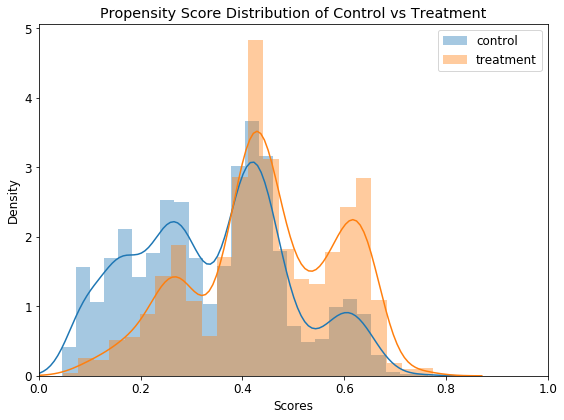

In [32]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

Keep in mind that not every plot will look like this, if there's major lack of overlap in some part of the propensity score distribution plot that means our positivity assumption would essentially be violated. Or in other words, we can't really estimate a causal effect in those area of the distribution since in those areas, those are subjects that have close to zero chance of being in the control/treatment group. One thing that we may wish to do when encountered with this scenario is either look and see if we're missing some covariates or get rid of individuals who have extreme propensity scores and focus on the areas where there are strong overlapping.

In [33]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
sim_indices

array([[1703],
       [1329],
       [2782],
       ...,
       [1728],
       [1909],
       [2546]], dtype=int64)

In [34]:
# We can still check the number of occurrences for the matched control record. As mentioned in the previous section, we can add these information as weights to our dataset, but we won't be doing that here.

_, counts = np.unique(sim_indices[:, 0], return_counts=True)
np.bincount(counts)

array([  0, 810, 309, 121,  47,  12,   6,   7,   3,   4], dtype=int64)

In [35]:
# After applying the matching procedure, it's important to check and validate that the matched dataset are indeed indistinguishable in terms of the covariates that we were using to balance the control and treatment group.

df_cleaned[TREATMENT] = treatment
df_cleaned[DEATH] = death
df_pos = df_cleaned[mask]
df_neg = df_cleaned[~mask].iloc[sim_indices[:, 0]]
df_matched = pd.concat([df_pos, df_neg], axis=0)
df_matched.head()

,age,meanbp1,cat1_chf,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_copd,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex,treatment,death
1,78.17896,63.0,0,0,0,0,0,0,0,1,0,1,1
2,46.09198,57.0,0,0,0,0,0,0,1,0,0,1,0
4,67.90997,65.0,0,0,0,0,0,0,0,1,1,1,1
9,48.42398,73.0,0,0,0,0,0,0,0,0,0,1,0
11,68.34796,50.0,0,0,0,0,0,0,0,0,1,1,0


In [36]:
table_one_matched = df_matched.groupby(TREATMENT).agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched)
table_one_smd_matched

,features,smd
0,age,0.0160
1,meanbp1,0.0072
2,cat1_chf,0.0184
3,cat1_cirrhosis,0.0091
4,cat1_colon_cancer,0.0707
5,cat1_coma,0.0091
6,cat1_copd,0.0557
7,cat1_lung_cancer,0.0626
8,cat1_mosf,0.0035
9,cat1_mosf_sepsis,0.0039


In [37]:
# Upon completing propensity score matching and verified that our covariates are now fairly balanced using standardized mean difference (smd), we can carry out a outcome analysis using a paired t-test. For all the various knobs that we've described when introducing the matching process, we can experiment with various options and see if our conclusions change.

num_matched_pairs = df_neg.shape[0]
print('number of matched pairs: ', num_matched_pairs)

# pair t-test
stats.ttest_rel(df_pos[DEATH].values, df_neg[DEATH].values)

number of matched pairs:  2184


Ttest_relResult(statistic=2.98993204105555, pvalue=0.0028215776367738962)

#### This result tells us after using matching adjustment to ensure comparability between the treatment and control group, we find that receiving Right Heart Catheterization does have an effect on a patient's change of dying.

## Reference

- [Blog: Comparative Statistics in Python using SciPy](http://benalexkeen.com/comparative-statistics-in-python-using-scipy/)   
- [Cousera: A Crash Course in Causality - Inferring Causal Effects from Observational Data](https://www.coursera.org/learn/crash-course-in-causality)   
- [Github: pymatch - Matching techniques for observational studies](https://github.com/benmiroglio/pymatch)   
- [Paper: B. Miroglio, D. Zeber, J. Kaye, R. Weiss - The Effect of Ad Blocking on User Engagement with the Web (2018)](https://dl.acm.org/doi/10.1145/3178876.3186162)   
- [The Effect of Ad Blocking on User Engagement with the Web](https://github.com/ethen8181/machine-learning/tree/master/ab_tests/causal_inference)
- [Introducing the pymatch Python Package](https://medium.com/@bmiroglio/introducing-the-pymatch-package-6a8c020e2009)